In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import datetime

now = datetime.datetime.now()

f'{now:%Y-%m-%d}/{now:%H-%M-%S}'

'2021-02-10/13-55-38'

In [2]:
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import json
import re

from ue4nlp.ue_scores import *
from ue4nlp.ue_variation_ratio import ue_variation_ratio

from utils.plot_error_detection import draw_charts
from utils.plot_error_detection import create_chart_data

import matplotlib.pyplot as plt
from utils.plot_error_detection import plot_error_detection


def plot_roc_auc(res_path):
    with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
    plot_error_detection(np.asarray(model_outputs['probabilities']), 
                         np.asarray(model_outputs['true_labels']), 
                         np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2))

In [3]:
default_methods = [
    'bald',
    'var_ratio',
    'entropy',
    'sampled_max_prob',
    'variance',
    'max_prob'
]

def plot_auc_averaged(aucs):
    plt.figure(dpi=150)
    for i, method in enumerate(default_methods):
        label = f'averaged {method}' if method != 'max_prob' else method
        plt.plot(np.arange(0, len(aucs)), aucs[:, i], label=label)
        plt.ylabel('roc-auc-score', fontdict={'size' : 5})
        plt.xlabel('averaged samples', fontdict={'size' : 5})
        plt.legend()

In [4]:
def average_result(task_path, n=10, verbose=True):
    probs = []
    aucs = []
    for folder in np.sort(os.listdir(task_path))[:n]:
        res_path = f'{task_path}/{folder}'
        with open(Path(res_path) / 'dev_inference.json') as f:
            model_outputs = json.load(f)
        probs.append(np.asarray(model_outputs['probabilities']))
        
        auc = plot_error_detection(np.asarray(model_outputs['probabilities']), 
                                   np.asarray(model_outputs['true_labels']), 
                                   np.asarray(np.asarray(probs).transpose(1, 0, 2)),
                                   verbose=verbose)
        aucs.append(auc)
        if verbose:
            plt.show()
    if not verbose:
        plot_error_detection(np.asarray(model_outputs['probabilities']), 
                             np.asarray(model_outputs['true_labels']), 
                             np.asarray(np.asarray(probs).transpose(1, 0, 2)))
    return np.asarray(aucs)

In [5]:
def average_result_mc(task_path, n=20, verbose=True):
    
    with open(Path(task_path) / 'dev_inference.json') as f:
        model_outputs = json.load(f)
        
    probs = []
    aucs = []
    for i in range(1, n+1):
        auc = plot_error_detection(np.asarray(model_outputs['probabilities']), 
                                   np.asarray(model_outputs['true_labels']), 
                                   np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2)[:, :i],
                                   verbose=verbose)
        aucs.append(auc)
        if verbose:
            plt.show()
    if not verbose:
        plot_error_detection(np.asarray(model_outputs['probabilities']), 
                                   np.asarray(model_outputs['true_labels']), 
                                   np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2)[:, :i])
        
    return np.asarray(aucs)

In [6]:
def print_result(dir_path, date, tasks, mc_types, n=10, print_rep='rep2', verbose=False):
    for task in tasks:
        for mc_type in mc_types:
            print(f'\n\t\tTask {task} with {mc_type}')
            task_path = f'{dir_path}/{task}/{mc_type}/0.63/{date}'

            print('\nSampled with different model:\n')
            aucs = average_result(task_path, n=n, verbose=verbose)
            plt.show()

            print(f'\nSampled with same model with repeat={print_rep}:\n')
            aucs_mc = average_result_mc(f'{task_path}/{print_rep}', verbose=verbose)
            plt.show()

            plot_auc_averaged(aucs)
            plt.title('Using probs with not active dropconnect for different models')
            plt.show()

            plot_auc_averaged(aucs_mc)
            plt.title('Using probs with active dropconnect for same model')
            plt.show()

In [7]:
tasks = ['cola', 'mrpc', 'sst-2']
mc_types = ['DC_MC_last', 'DC_MC_all']
path = "../workdir/results/deep_ensemble"
date = '2021-01-26'


		Task cola with DC_MC_last

Sampled with different model:

bald: 0.7933122250688839
var_ratio: 0.723368943458855
entropy: 0.8076207279934258
sampled_max_prob: 0.8076287845829104
variance: 0.7969054639789885
max_prob: 0.7520947132659803


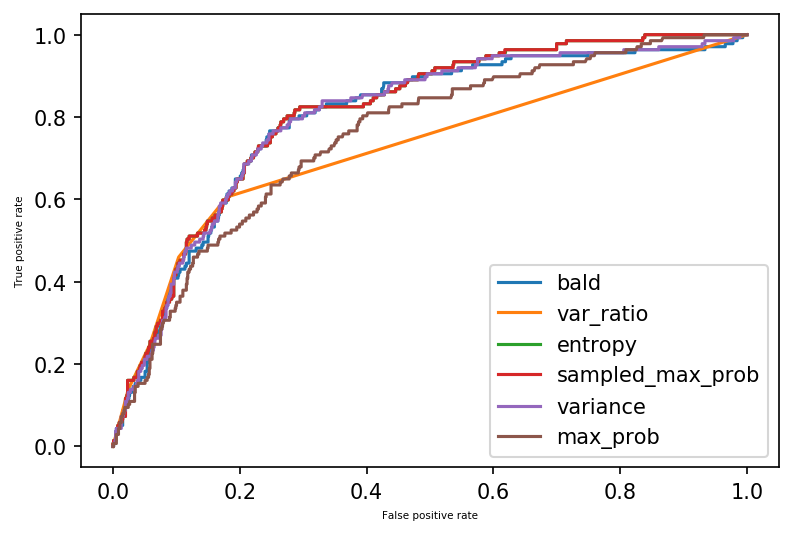


Sampled with same model with repeat=rep2:

bald: 0.771772521311727
var_ratio: 0.5087090085246908
entropy: 0.7610513785423547
sampled_max_prob: 0.7610206589355657
variance: 0.7666193072728669
max_prob: 0.7605560248828815


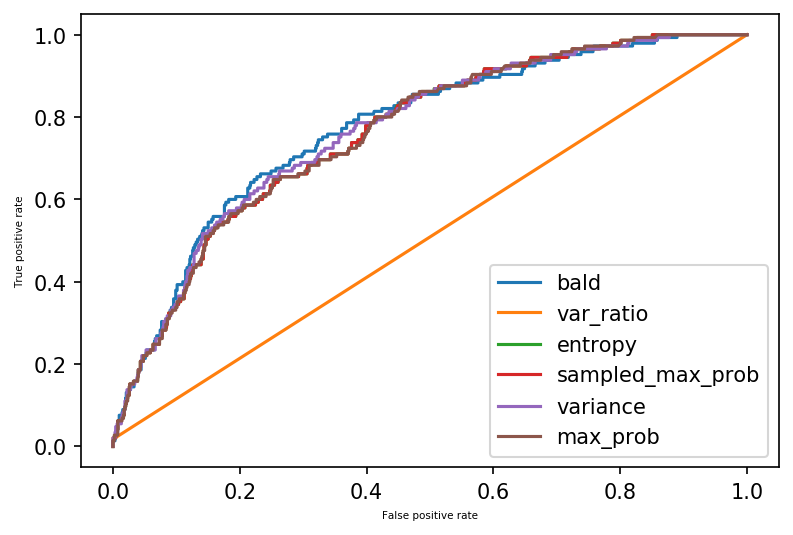

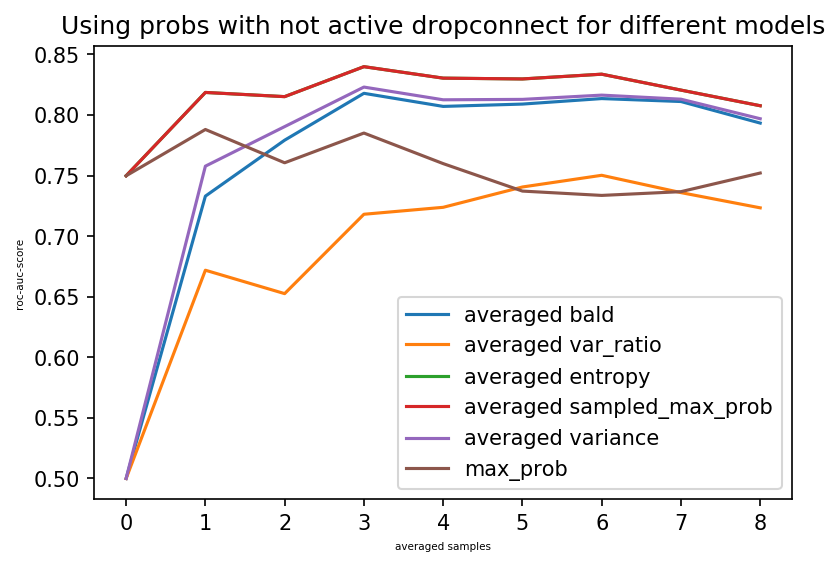

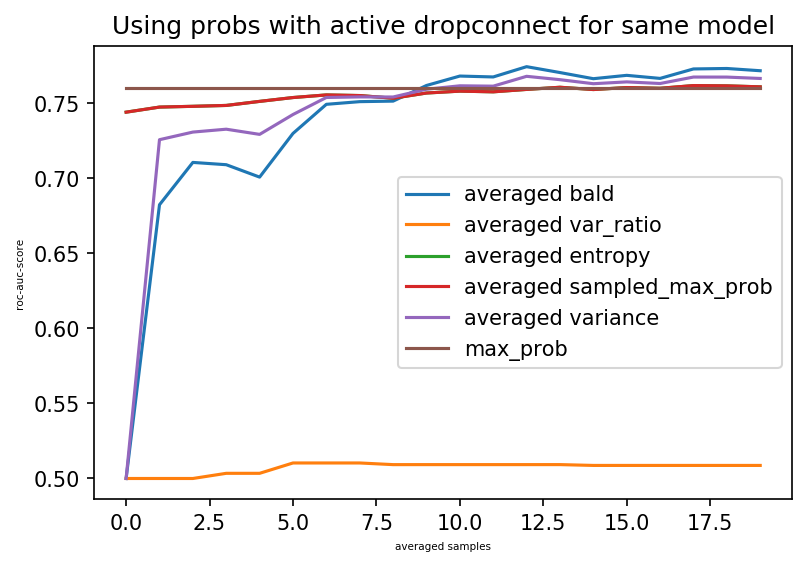


		Task cola with DC_MC_all

Sampled with different model:

bald: 0.824137886475823
var_ratio: 0.860888086766999
entropy: 0.8844750648254236
sampled_max_prob: 0.8844729111568645
variance: 0.8353326556456269
max_prob: 0.49016634935949904


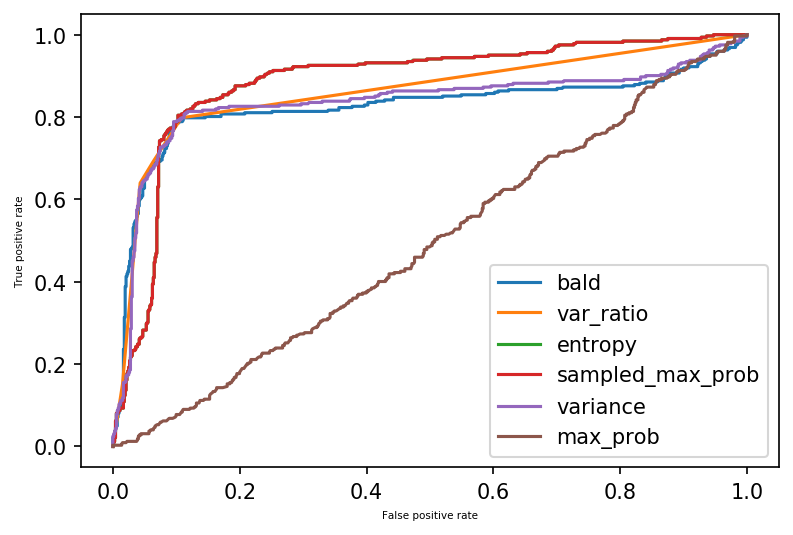


Sampled with same model with repeat=rep2:

bald: 0.7838487471905435
var_ratio: 0.7475165792613558
entropy: 0.7982428757734676
sampled_max_prob: 0.7982428757734676
variance: 0.7885866699963927
max_prob: 0.713934903854158


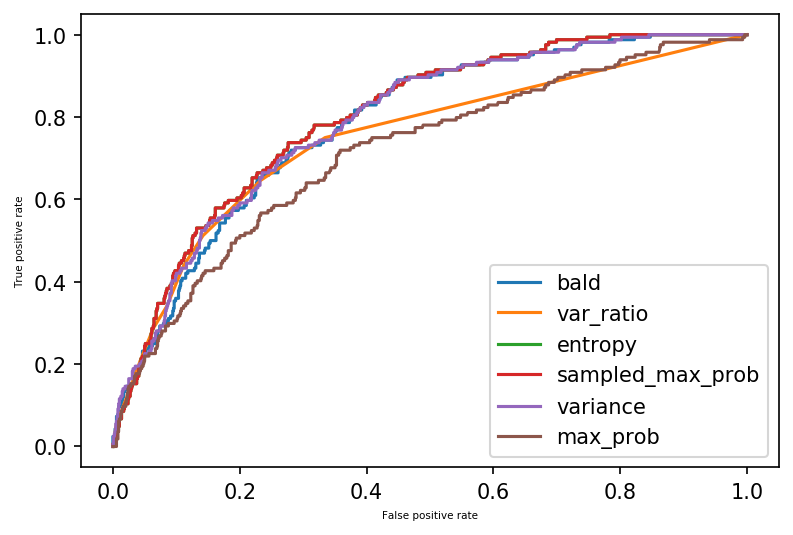

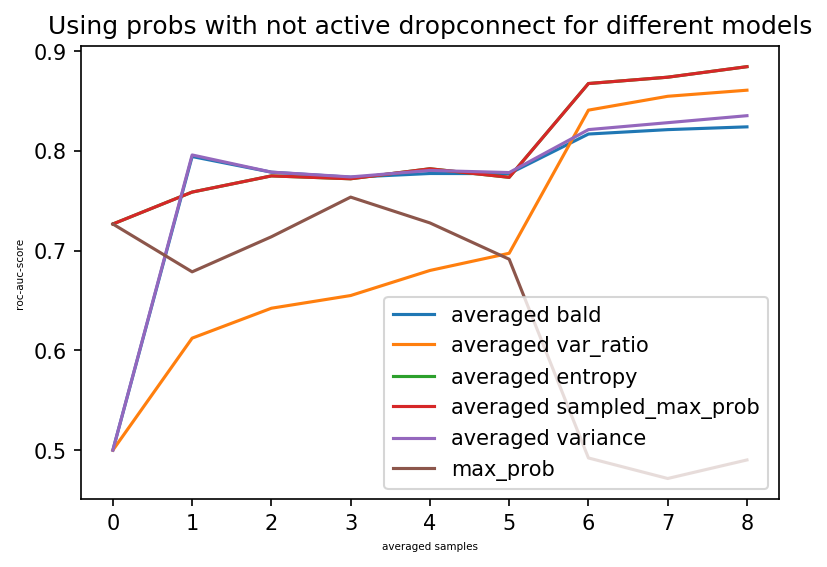

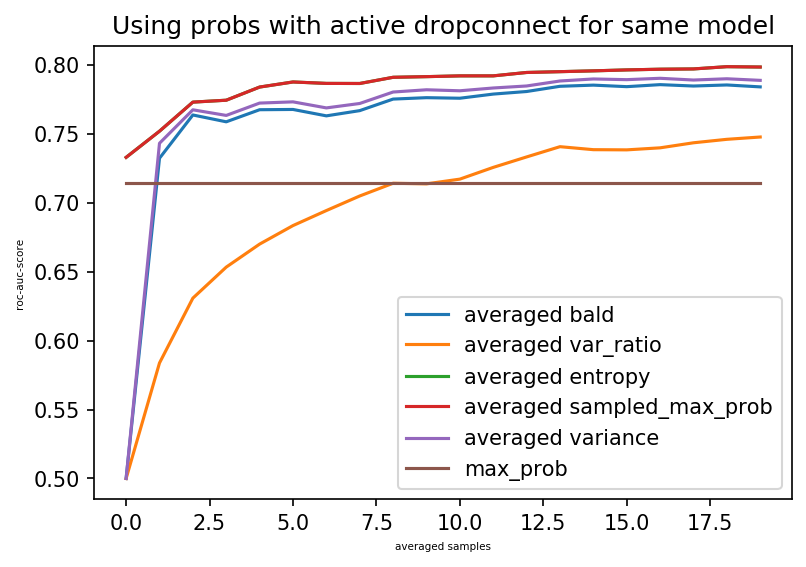


		Task mrpc with DC_MC_last

Sampled with different model:

bald: 0.8294416611403064
var_ratio: 0.7642454707065752
entropy: 0.8287367019053403
sampled_max_prob: 0.8287353087052713
variance: 0.8288955267132181
max_prob: 0.7770239017403855


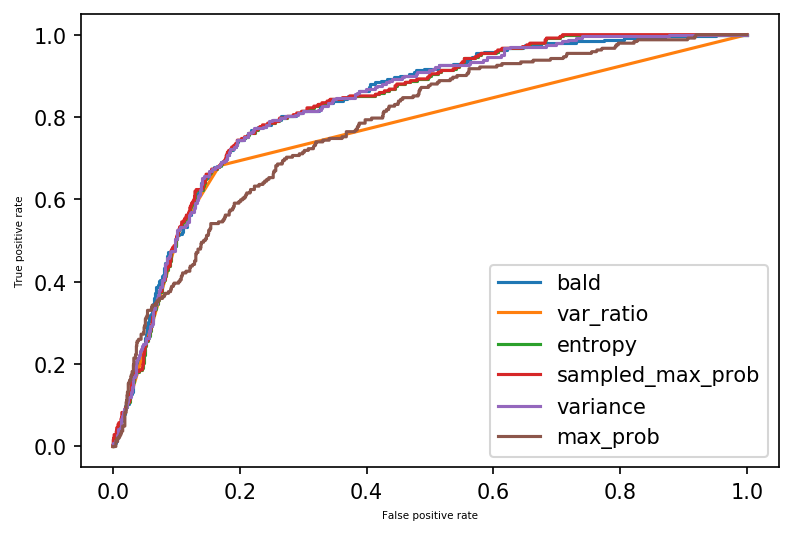


Sampled with same model with repeat=rep2:

bald: 0.7422166772227926
var_ratio: 0.5087429292157163
entropy: 0.7733963788848364
sampled_max_prob: 0.7733963788848364
variance: 0.7571499552274662
max_prob: 0.7721937995500906


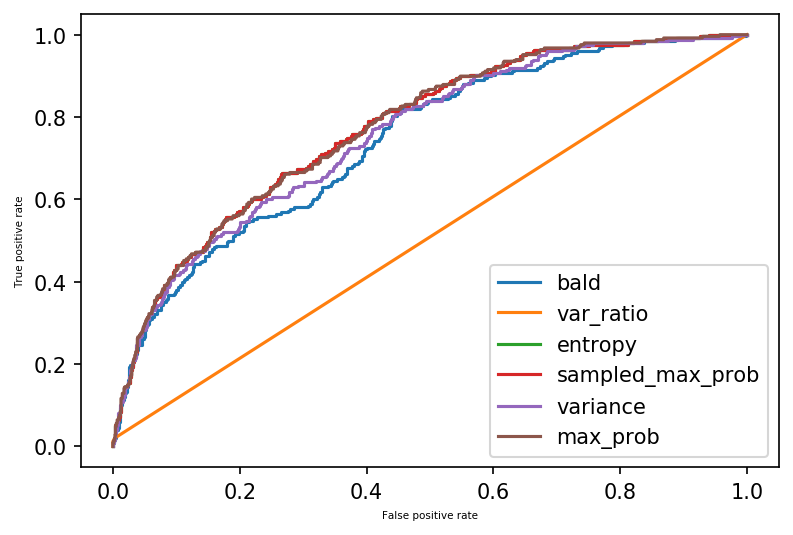

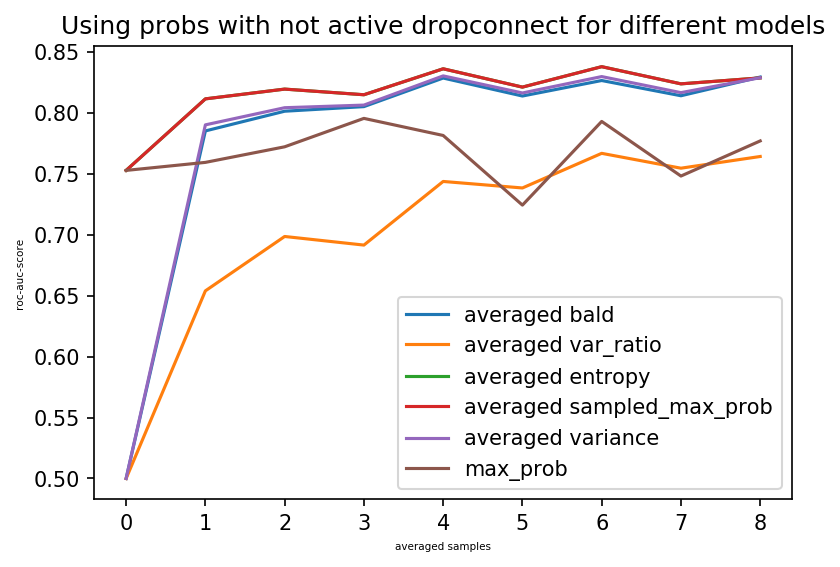

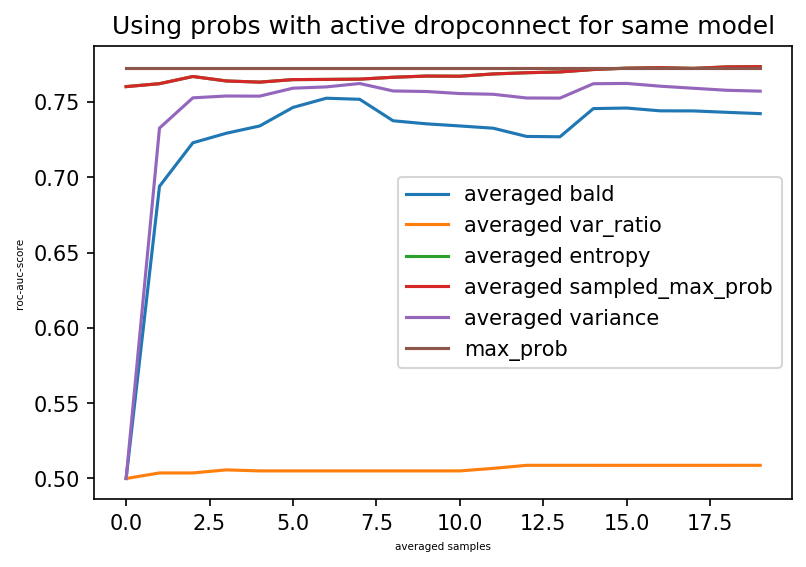


		Task mrpc with DC_MC_all

Sampled with different model:

bald: 0.8157235990030585
var_ratio: 0.752821584440744
entropy: 0.8134434758002199
sampled_max_prob: 0.8134434758002199
variance: 0.8169126369978558
max_prob: 0.7838835014856173


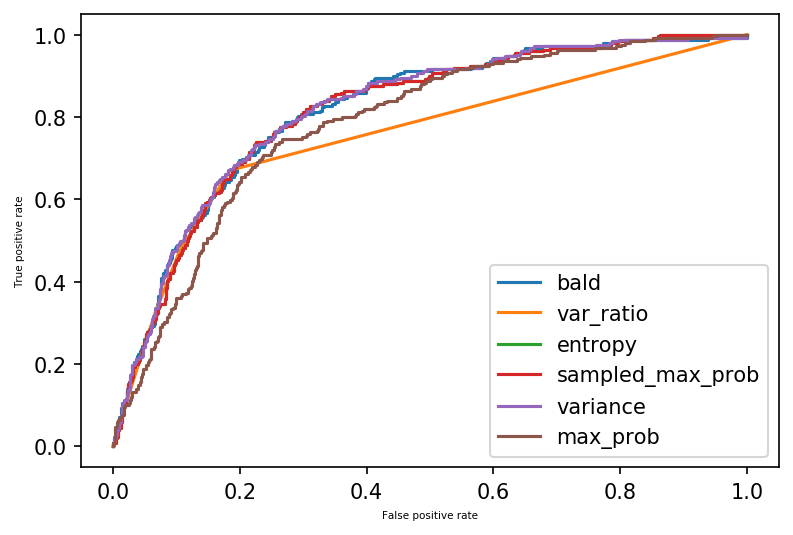


Sampled with same model with repeat=rep2:

bald: 0.7974256913931249
var_ratio: 0.7786055828379426
entropy: 0.8090255880072371
sampled_max_prob: 0.8090255880072371
variance: 0.8008555182217628
max_prob: 0.8136172137503231


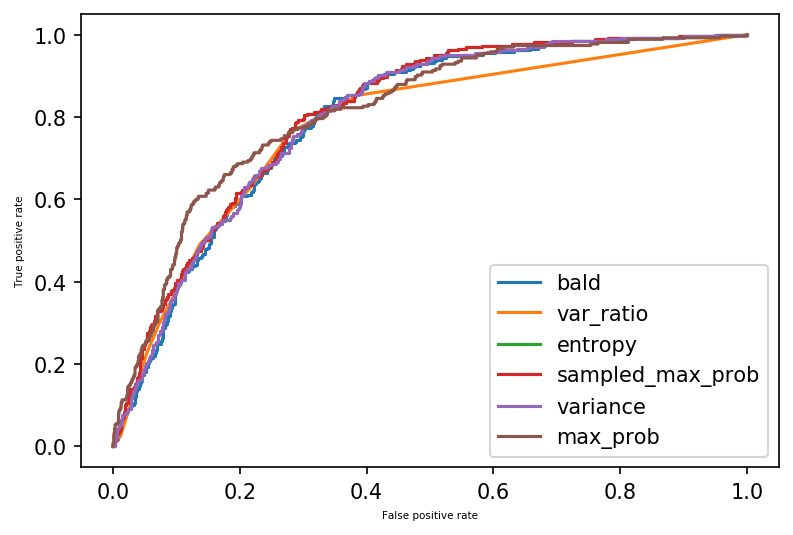

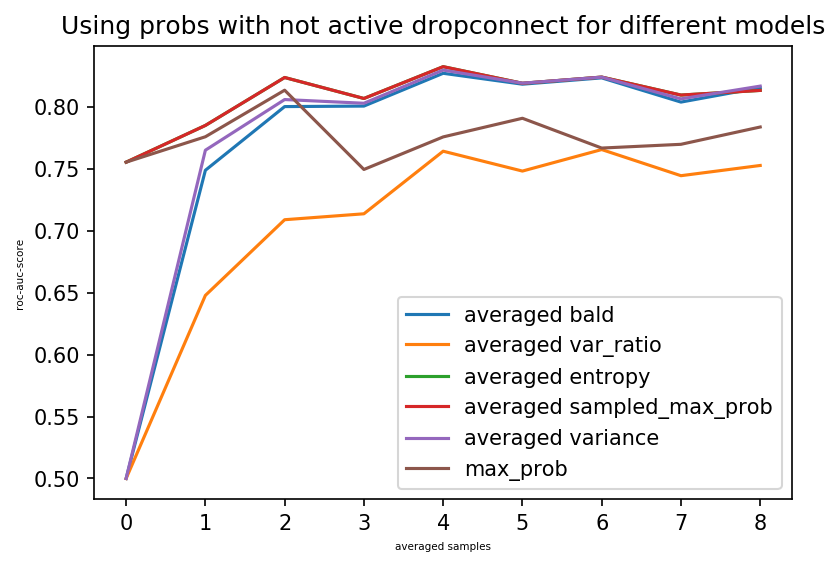

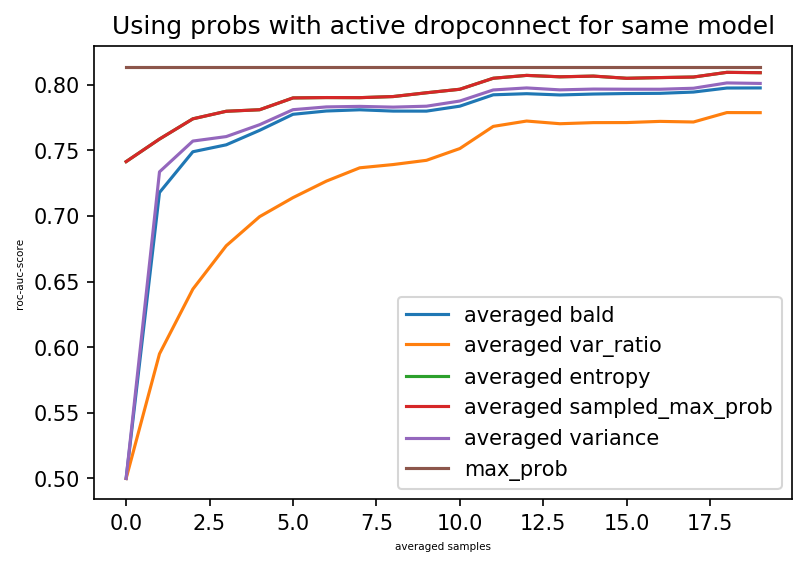


		Task sst-2 with DC_MC_last

Sampled with different model:

bald: 0.8692651238327243
var_ratio: 0.7676912421485038
entropy: 0.8753552578156718
sampled_max_prob: 0.8753552578156719
variance: 0.8706742136562299
max_prob: 0.7802297532898665


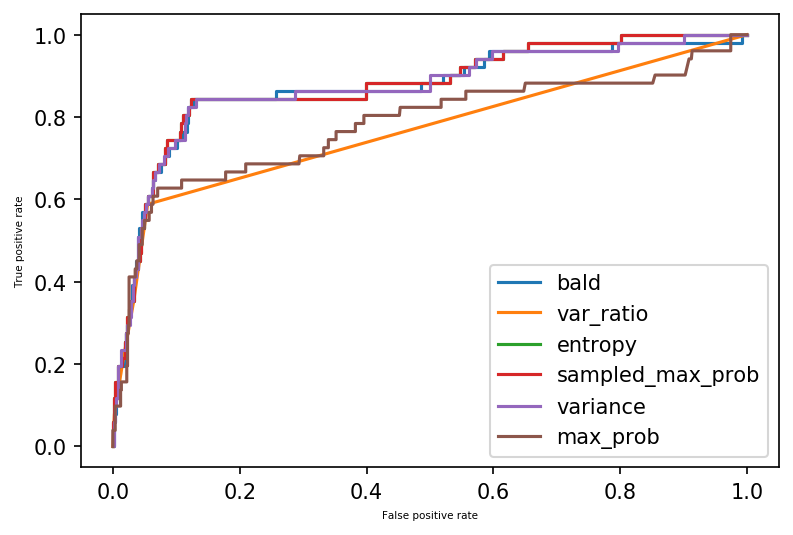


Sampled with same model with repeat=rep2:

bald: 0.8162860576923077
var_ratio: 0.5
entropy: 0.8276742788461539
sampled_max_prob: 0.8276893028846154
variance: 0.820703125
max_prob: 0.8327674278846153


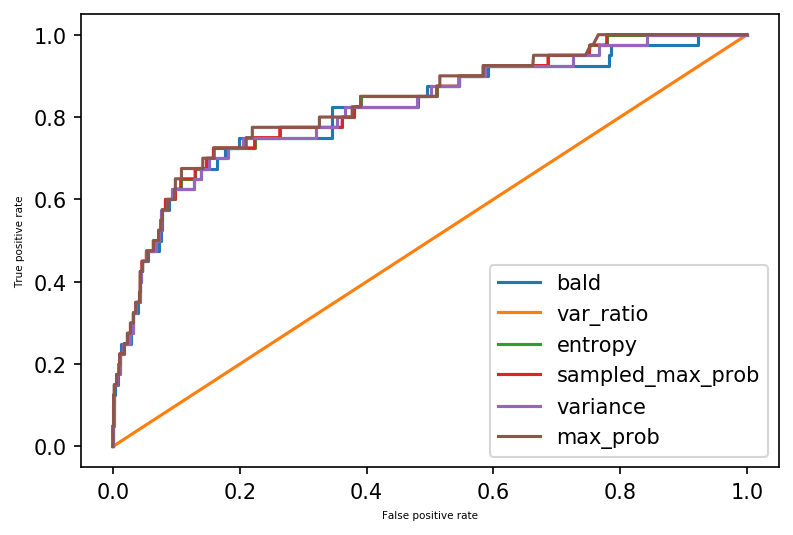

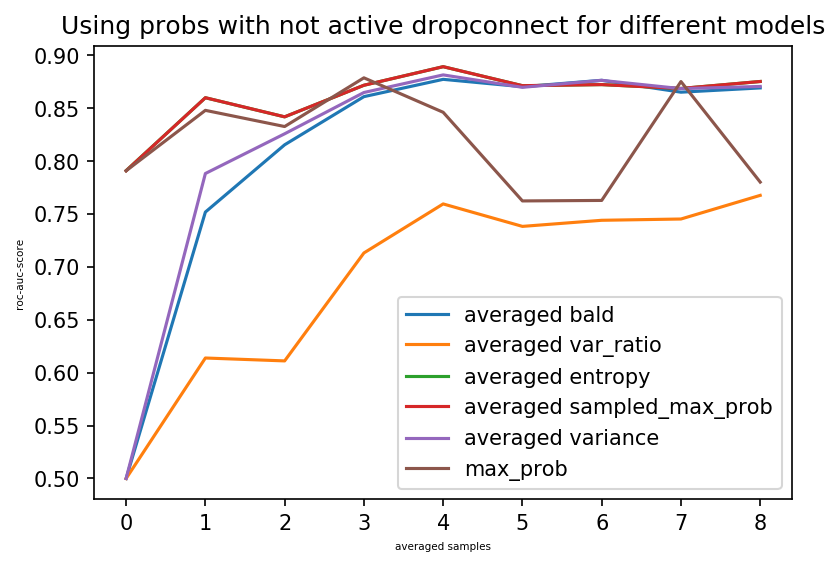

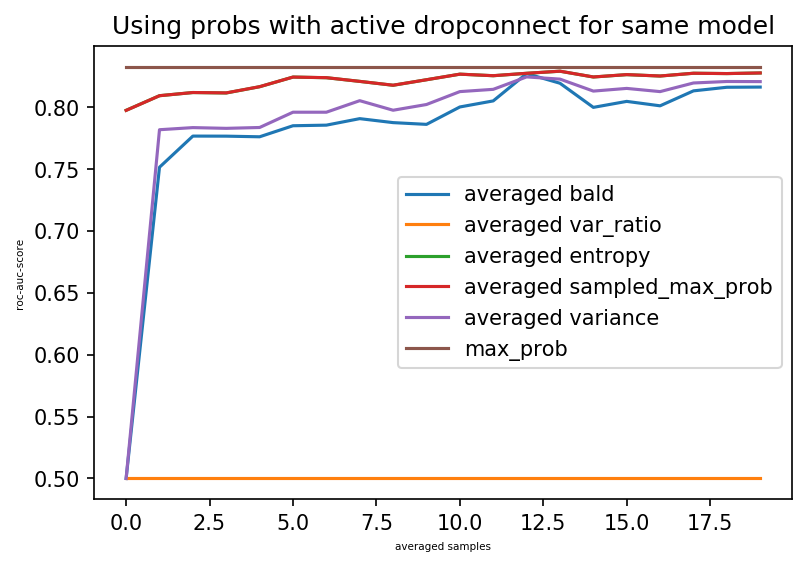


		Task sst-2 with DC_MC_all

Sampled with different model:

bald: 0.8839502427184466
var_ratio: 0.7329591423948221
entropy: 0.8842536407766991
sampled_max_prob: 0.8842536407766991
variance: 0.8840260922330098
max_prob: 0.8690458131067962


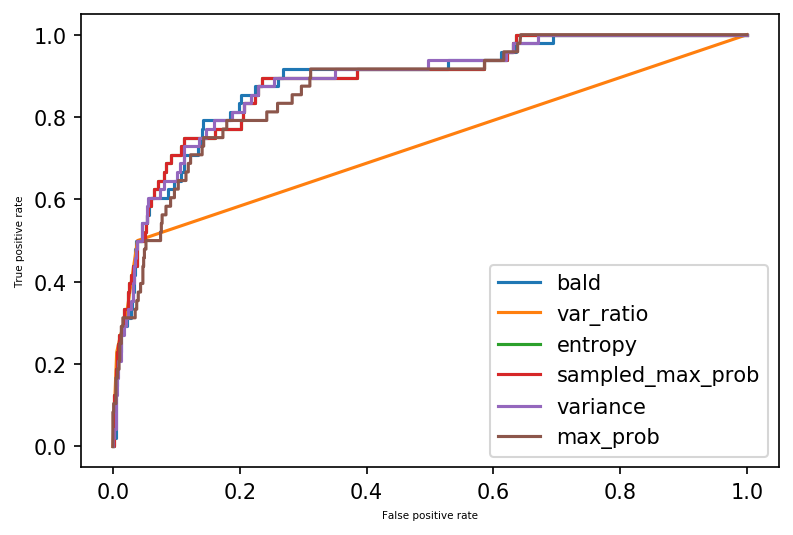


Sampled with same model with repeat=rep2:

bald: 0.8861498786407767
var_ratio: 0.747977346278317
entropy: 0.8745449029126214
sampled_max_prob: 0.8745449029126214
variance: 0.8851891181229774
max_prob: 0.8284916059870551


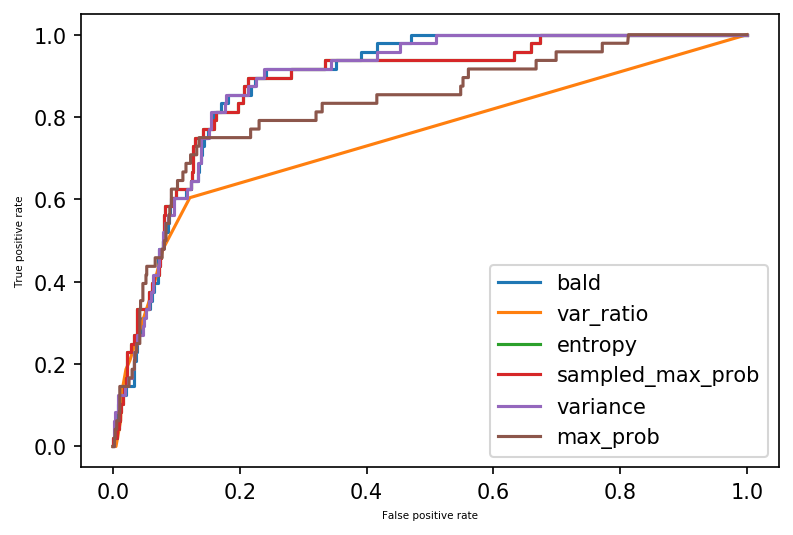

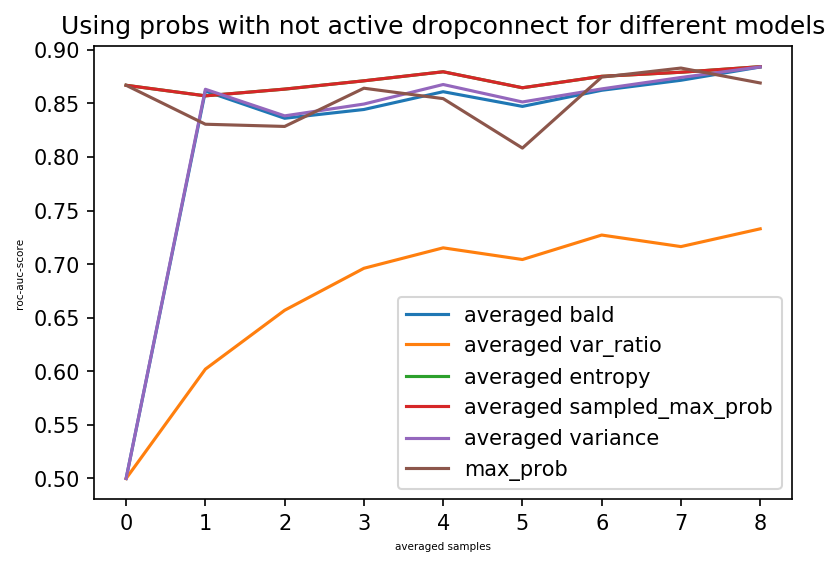

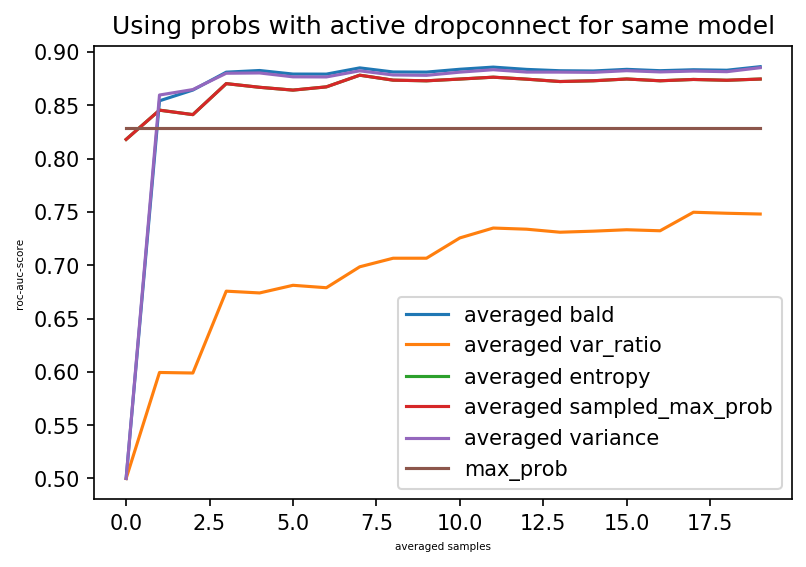

In [8]:
print_result(path, date, tasks, mc_types, n=9)